In [7]:
import sys
import os
import pickle
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from lightgbm import LGBMRegressor

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]

In [4]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[bias_score_key]

chain_target_metrics=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"]

In [5]:
cv_result_path="experiment_result/Q3_result.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

In [6]:
cv_result_df

,target_order,Fold,label,MAE,MSE,RMSE,MAPE,SMAPE,MSLE
0,"['Group Size Disparity', 'Prevalence Disparity...",0,Group Size Disparity,0.292743,0.131943,0.363240,5.970875e+12,0.639764,0.055871
1,"['Group Size Disparity', 'Prevalence Disparity...",0,Prevalence Disparity,0.061928,0.006520,0.080745,3.723652e+01,0.826891,0.004894
2,"['Group Size Disparity', 'Prevalence Disparity...",0,equal_opportunity,0.119484,0.030241,0.173899,3.210948e+12,0.783815,0.017068
3,"['Group Size Disparity', 'Prevalence Disparity...",0,disparate_parity,0.103535,0.019071,0.138097,2.364086e+12,0.747191,0.011856
4,"['Group Size Disparity', 'Prevalence Disparity...",0,individual_fairness,0.143102,0.034301,0.185206,1.188725e+00,0.488181,0.012815
...,...,...,...,...,...,...,...,...,...
6545,EnsembleTop100%,9,Group Size Disparity,0.298448,0.132536,0.364055,3.523302e+12,0.645820,0.056772
6546,EnsembleTop100%,9,Prevalence Disparity,0.055480,0.005597,0.074811,1.681218e+11,0.762785,0.004200
6547,EnsembleTop100%,9,equal_opportunity,0.109628,0.026161,0.161742,2.309317e+12,0.734829,0.015100
6548,EnsembleTop100%,9,disparate_parity,0.093993,0.016558,0.128679,1.158238e+12,0.682827,0.010217


Our intuition to train ensemble chain models is to first find out which target order work best for the meta-dataset and select best of them as the ensemble's predictors. To make predictions, the ensemble will let their predictors make predictions, the ensemble model will then average them and output the aggregated result

As a result, to evaluate the ensemble, we need to run experiments for Q3 on training sets for each validation folds. This exponentially increase the computational and time resource required to run the experiment. Thus this notebook is developed to run the small parts of the experiment in multiple session. Which part to run is determined by the value of `fold_index` in the following code blocks.

In [9]:
ensemble_cv_split={}
for index,(train_index,test_index) in enumerate(KFold(n_splits=10,shuffle=True,random_state=1000).split(X,Y)):
    ensemble_cv_split[index]=(train_index,test_index)
ensemble_cv_split

{0: (array([    0,     1,     2, ..., 19998, 19999, 20000]),
  array([    3,     8,    26, ..., 19992, 19993, 20001])),
 1: (array([    1,     2,     3, ..., 19999, 20000, 20001]),
  array([    0,     7,    14, ..., 19978, 19982, 19995])),
 2: (array([    0,     2,     3, ..., 19998, 19999, 20001]),
  array([    1,     6,    35, ..., 19986, 19994, 20000])),
 3: (array([    0,     1,     2, ..., 19999, 20000, 20001]),
  array([    4,    11,    19, ..., 19985, 19991, 19996])),
 4: (array([    0,     1,     2, ..., 19999, 20000, 20001]),
  array([   13,    24,    31, ..., 19977, 19983, 19990])),
 5: (array([    0,     1,     3, ..., 19999, 20000, 20001]),
  array([    2,    17,    18, ..., 19980, 19987, 19998])),
 6: (array([    0,     1,     2, ..., 19998, 20000, 20001]),
  array([   23,    29,    38, ..., 19984, 19988, 19999])),
 7: (array([    0,     1,     2, ..., 19999, 20000, 20001]),
  array([    5,     9,    10, ..., 19981, 19989, 19997])),
 8: (array([    0,     1,     2, ..., 19

In [10]:
#KFold parameters during Grid Search hyperparmeter tuning
gridCV_settings={
    "n_splits":5,
    "shuffle":True,
    "random_state":240
}
#KFold parameters during training RegressorChain models
chainCV_settings={
    "n_splits":5,
    "shuffle":True,
    "random_state":420
}
#Base Parameters of LightGBM
lightGBM_base={
    "objective":"regression", 
    "n_jobs":8, 
    "random_state":700, 
    "device_type":"gpu",
    "verbosity":-1
}
#LGBMRegressor parameters tuned in Grid Search
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[5,10,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}

In [97]:
fold_index=9

train_fold, test_fold=ensemble_cv_split[fold_index]
train_X,train_Y,test_X,test_Y=X.iloc[train_fold],Y.iloc[train_fold],X.iloc[test_fold],Y.iloc[test_fold]

chain_cv_fold_settings={
    "n_splits":5,
    "shuffle":True,
    "random_state":1100+fold_index*100
}

indie_chain_result,chain_experiment_status=pd.DataFrame(),pd.DataFrame(
    [pd.Series(list(itertools.permutations(chain_target_metrics))), pd.Series(np.full(120,False))], index=["target_chain","complete"]).T
fold_index

9

In [98]:
best_parameters={}
grid_CV=KFold(**gridCV_settings)
for index,(train_index,_) in enumerate(KFold(**chain_cv_fold_settings).split(train_X,train_Y)):
    for bm in tqdm(chain_target_metrics,total=len(chain_target_metrics),desc=f"Fold ({index}):"):
        gridSearch=GridSearchCV(LGBMRegressor(**lightGBM_base),lightgbm_parameters,cv=grid_CV,n_jobs=5)
        gridSearch.fit(train_X.iloc[train_index],train_Y.iloc[train_index][bm])
        best_parameters[(bm,index)]=gridSearch.best_params_

Fold (4):: 100%|██████████| 5/5 [25:41<00:00, 308.36s/it]


In [14]:
def symmetry_mean_aboslute_percentage_error(truth,pred):
    truth=truth.to_numpy()
    pred=pred.to_numpy()
    smape = np.abs(pred - truth) / (np.abs(truth)+np.abs(pred))*2
    output_errors = np.average(smape, axis=0)
    return output_errors

In [15]:
def cross_validate_chain(model, base_param, chain_data_index,random_state):
    target_order=list(chain_experiment_status.iloc[chain_data_index]["target_chain"])
    cv_result=[]
    #Initiating KFold instants with parameters
    k_fold=KFold(**chain_cv_fold_settings)
    chain_cv=KFold(**chainCV_settings)
    for index,(train_index,test_index) in enumerate(tqdm(k_fold.split(train_X,train_Y), total=k_fold.get_n_splits(), desc=f"Chain {chain_data_index}: ")):
        hyperparameters=best_parameters[(target_order[0],index)]
        hyperparameters.update(base_param)
        best_model=model(**hyperparameters)
        order=[target_order.index(t) for t in target_order]

        #Train RegressoChain models with the head models' hyperparameters
        chain_model=RegressorChain(base_estimator=best_model,order=order,random_state=random_state,cv=chain_cv)
        chain_model.fit(train_X.iloc[train_index],train_Y.iloc[train_index][target_order])
        pred=chain_model.predict(train_X.iloc[test_index])
        if np.isinf(pred).any():
            continue
        pred=pd.DataFrame(pred,columns=target_order)
        truth=train_Y.iloc[test_index][target_order]

        #Caluate metrics for all target metrics
        for target in truth.columns:
            mae=mean_absolute_error(truth[target],pred[target])
            mse=mean_squared_error(truth[target],pred[target])
            rmse=root_mean_squared_error(truth[target],pred[target])
            mape=mean_absolute_percentage_error(truth[target],pred[target])
            smape=symmetry_mean_aboslute_percentage_error(truth[target],pred[target])
            msle=mean_squared_log_error(np.abs(truth[target]),np.abs(pred[target]))
            cv_result.append({
                "target_order":target_order,
                "Fold":index,
                "label": target,
                "MAE":mae,
                "MSE":mse,
                "RMSE":rmse,
                "MAPE":mape,
                "SMAPE":smape,
                "MSLE":msle
            })
    result_df=pd.DataFrame(cv_result)
    return result_df

In [99]:
for i in chain_experiment_status[chain_experiment_status["complete"]==False].index:
    result=cross_validate_chain(LGBMRegressor,lightGBM_base,i,100)
    indie_chain_result=pd.concat([indie_chain_result,result])
    chain_experiment_status.at[i,"complete"]=True;

Chain 119: 100%|██████████| 5/5 [05:32<00:00, 66.43s/it]


In [11]:
#Chain sequences are stored in string, so this method help translate sting into list
def parse_target_order(target_chain):
    if type(target_chain) == tuple:
        return list(target_chain)
    chain_candidate=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"]
    str_index=[target_chain.find(cc) for cc in chain_candidate]
    output=[]
    threshold=-1
    while len(output)<5:
        min_index=min([i for i in str_index if i>threshold])
        output.append(chain_candidate[str_index.index(min_index)])
        threshold=min_index
    return output

#Calculate the average of chain models' result
def get_average_result(result_df):
    average_df=[]
    possible_labels=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"]
    for model in result_df["target_order"].unique():
        model_df=result_df[result_df["target_order"]==model]
        for label in possible_labels:
            label_df=model_df[model_df["label"]==label][["MAE","MSE","RMSE","MAPE","SMAPE","MSLE"]]
            label_average=label_df.sum()/len(label_df)
            average_df.append({
                "target_order":model,
                "label":label,
                "MAE":label_average["MAE"],
                "MSE":label_average["MSE"],
                "RMSE":label_average["RMSE"],
                "MAPE":label_average["MAPE"],
                "SMAPE":label_average["SMAPE"],
                "MSLE":label_average["MSLE"]
            })
    return pd.DataFrame(average_df)

In [100]:
indie_chain_result=indie_chain_result.reset_index(drop=True)
indie_chain_result["target_order"]=indie_chain_result["target_order"].astype(np.str_)

indie_chain_average_result=get_average_result(indie_chain_result)
indie_chain_average_result=indie_chain_average_result.drop(["MAE","MSE","MAPE","SMAPE","MSLE"],axis=1)

indie_chain_ranking=indie_chain_average_result.copy()
for label in ["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"]:
    label_result=indie_chain_ranking[indie_chain_ranking["label"]==label]
    for index,row in label_result["RMSE"].rank().items():
        indie_chain_ranking.at[index,"RMSE"]=row

sum_of_rank=[]
for to in indie_chain_ranking["target_order"].unique():
    model_percentile_df=indie_chain_ranking[indie_chain_ranking["target_order"]==to]
    sum_of_rank.append({
        "target_order":to,
        "RMSE rank":model_percentile_df["RMSE"].sum()
    })
indie_chain_ranking=pd.DataFrame(sum_of_rank)
indie_chain_ranking=indie_chain_ranking.sort_values("RMSE rank")
indie_chain_ranking

,target_order,RMSE rank
112,"['individual_fairness', 'equal_opportunity', '...",192.0
119,"['individual_fairness', 'disparate_parity', 'e...",201.0
95,"['disparate_parity', 'individual_fairness', 'e...",201.0
111,"['individual_fairness', 'equal_opportunity', '...",208.0
94,"['disparate_parity', 'individual_fairness', 'e...",208.0
...,...,...
8,"['Group Size Disparity', 'equal_opportunity', ...",412.0
14,"['Group Size Disparity', 'disparate_parity', '...",418.0
7,"['Group Size Disparity', 'equal_opportunity', ...",420.0
0,"['Group Size Disparity', 'Prevalence Disparity...",430.0


In [101]:
headmodel_param={}
for bm in tqdm(chain_target_metrics,desc="hyperparameter"):
    grid_cv=KFold(**gridCV_settings)
    gridSearch=GridSearchCV(LGBMRegressor(**lightGBM_base),lightgbm_parameters,cv=grid_cv,n_jobs=5)
    gridSearch.fit(train_X,train_Y[bm])
    headmodel_param[bm]=gridSearch.best_params_

hyperparameter: 100%|██████████| 5/5 [27:04<00:00, 324.92s/it]


In [102]:
with open("best_param.pickle","wb") as file:
    pickle.dump(headmodel_param,file)

In [103]:
for target_chain in tqdm(indie_chain_ranking["target_order"],desc="training_indie_chain"):
    chain=parse_target_order(target_chain)
    optimised_parameter=lightGBM_base
    if chain[0] in headmodel_param:
        optimised_parameter.update(headmodel_param[chain[0]])
    order=[chain.index(t) for t in chain]
    cv=KFold(**chainCV_settings)
    chainModel = RegressorChain(base_estimator=LGBMRegressor(**optimised_parameter), order=order, random_state=1111,cv=cv)
    chainModel.fit(train_X, train_Y[chain])
    with open(f"chain_model_storage/{target_chain}.pickle","wb") as file:
        pickle.dump(chainModel,file)

training_indie_chain: 100%|██████████| 120/120 [1:08:34<00:00, 34.29s/it]


In [22]:
#Average Ensemble RegressorChain models. It will train several chain models based on the sequence entailed in chain_selection
#When prediction, it make several prediction with each chain model and take their average as its own prediction.
class EnsembleChain:
    def __init__(self,chain_selection, chaincv_setting):
        self.chain_selection = chain_selection
        self.chaincv_setting=chaincv_setting
    
    def fit(self,X,Y):
        pass
            
    def predict(self, X):
        preds = pd.DataFrame(np.zeros((len(X),5)),columns=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"])
        valid_chain=len(self.chain_selection)
        for target_order in self.chain_selection:
            with open(f"chain_model_storage/{target_order}.pickle","rb") as file:
                chain=pickle.load(file)
                chain_pred=chain.predict(X)
            if np.isinf(chain_pred).any():
                valid_chain-=1
                continue
            preds += pd.DataFrame(chain_pred,columns=parse_target_order(target_order))
        return preds / valid_chain

In [23]:
def train_and_evaluate_ensemble(ensemble_name,ensemble_selection):
    result=[]
    ensemble_model=EnsembleChain(ensemble_selection,chainCV_settings)
    ensemble_model.fit(train_X,train_Y)
    pred=ensemble_model.predict(test_X)
    truth=test_Y[chain_target_metrics]

    for target in truth.columns:
        mae=mean_absolute_error(truth[target],pred[target])
        mse=mean_squared_error(truth[target],pred[target])
        rmse=root_mean_squared_error(truth[target],pred[target])
        mape=mean_absolute_percentage_error(truth[target],pred[target])
        smape=symmetry_mean_aboslute_percentage_error(truth[target],pred[target])
        msle=mean_squared_log_error(np.abs(truth[target]),np.abs(pred[target]))
        result.append({
            "target_order":ensemble_name,
            "Fold":fold_index,
            "label": target,
            "MAE":mae,
            "MSE":mse,
            "RMSE":rmse,
            "MAPE":mape,
            "SMAPE":smape,
            "MSLE":msle
        })
    return result

In [104]:
ensemble_result=[]
for i in tqdm(list(range(5,55,5))+[100]):
    ensemble_selection=indie_chain_ranking.head(int(i*1.2))["target_order"]
    ensemble_result+=train_and_evaluate_ensemble(f"EnsembleTop{i}%",ensemble_selection)
ensemble_result=pd.DataFrame(ensemble_result)
ensemble_result

100%|██████████| 11/11 [00:15<00:00,  1.38s/it]


,target_order,Fold,label,MAE,MSE,RMSE,MAPE,SMAPE,MSLE
0,EnsembleTop5%,9,Group Size Disparity,0.308701,0.143864,0.379294,3.206523e+12,0.663071,0.061484
1,EnsembleTop5%,9,Prevalence Disparity,0.055503,0.005894,0.076771,1.411913e+11,0.755906,0.004433
2,EnsembleTop5%,9,equal_opportunity,0.107349,0.026996,0.164304,1.383345e+12,0.700312,0.015739
3,EnsembleTop5%,9,disparate_parity,0.094773,0.017768,0.133297,4.281103e+11,0.674420,0.010964
4,EnsembleTop5%,9,individual_fairness,0.020169,0.000933,0.030542,7.145443e-02,0.064961,0.000321
5,EnsembleTop10%,9,Group Size Disparity,0.304757,0.139294,0.373221,3.257850e+12,0.656335,0.059538
6,EnsembleTop10%,9,Prevalence Disparity,0.055091,0.005757,0.075876,1.548852e+11,0.754678,0.004324
7,EnsembleTop10%,9,equal_opportunity,0.107037,0.026295,0.162158,1.636754e+12,0.708885,0.015257
8,EnsembleTop10%,9,disparate_parity,0.093688,0.017130,0.130881,6.637905e+11,0.672522,0.010568
9,EnsembleTop10%,9,individual_fairness,0.028238,0.001818,0.042637,9.851740e-02,0.087485,0.000630


In [9]:
#Save Cross Validation Results
cv_result_df=pd.concat([cv_result_df,ensemble_result])
cv_result_df=cv_result_df.reset_index(drop=True)
cv_result_df.to_csv(cv_result_path)
cv_result_df

,target_order,Fold,label,MAE,MSE,RMSE,MAPE,SMAPE,MSLE
0,"['Group Size Disparity', 'Prevalence Disparity...",0,Group Size Disparity,0.292743,0.131943,0.363240,5.970875e+12,0.639764,0.055871
1,"['Group Size Disparity', 'Prevalence Disparity...",0,Prevalence Disparity,0.061928,0.006520,0.080745,3.723652e+01,0.826891,0.004894
2,"['Group Size Disparity', 'Prevalence Disparity...",0,equal_opportunity,0.119484,0.030241,0.173899,3.210948e+12,0.783815,0.017068
3,"['Group Size Disparity', 'Prevalence Disparity...",0,disparate_parity,0.103535,0.019071,0.138097,2.364086e+12,0.747191,0.011856
4,"['Group Size Disparity', 'Prevalence Disparity...",0,individual_fairness,0.143102,0.034301,0.185206,1.188725e+00,0.488181,0.012815
...,...,...,...,...,...,...,...,...,...
6544,EnsembleTop100%,9,Group Size Disparity,0.298448,0.132536,0.364055,3.523302e+12,0.645820,0.056772
6545,EnsembleTop100%,9,Prevalence Disparity,0.055480,0.005597,0.074811,1.681218e+11,0.762785,0.004200
6546,EnsembleTop100%,9,equal_opportunity,0.109628,0.026161,0.161742,2.309317e+12,0.734829,0.015100
6547,EnsembleTop100%,9,disparate_parity,0.093993,0.016558,0.128679,1.158238e+12,0.682827,0.010217


In [12]:
average_df=get_average_result(cv_result_df)
average_df.to_csv("experiment_result/stage2_average.csv")
average_df=average_df.drop(["MAE","MSE","MAPE","SMAPE","MSLE"],axis=1)
average_df

,target_order,label,RMSE
0,"['Group Size Disparity', 'Prevalence Disparity...",Group Size Disparity,0.361813
1,"['Group Size Disparity', 'Prevalence Disparity...",Prevalence Disparity,0.079905
2,"['Group Size Disparity', 'Prevalence Disparity...",equal_opportunity,0.166561
3,"['Group Size Disparity', 'Prevalence Disparity...",disparate_parity,0.135819
4,"['Group Size Disparity', 'Prevalence Disparity...",individual_fairness,0.187643
...,...,...,...
650,EnsembleTop100%,Group Size Disparity,0.365790
651,EnsembleTop100%,Prevalence Disparity,0.075601
652,EnsembleTop100%,equal_opportunity,0.211958
653,EnsembleTop100%,disparate_parity,0.128370


In [14]:
#Insert the result of individual predictors
individual_average_df=pd.read_csv("experiment_result/Q2_average_result.csv",index_col=0)
individual_average_df=individual_average_df[individual_average_df["Model"]=="LightGBM"][~(individual_average_df["label"]==
                                                                                          "group_fairness")][["Model","label","RMSE"]]
individual_average_df=individual_average_df.rename(columns={'Model': 'target_order'})
average_df=pd.concat([individual_average_df,average_df],ignore_index=True)
average_df

,target_order,label,RMSE
0,LightGBM,Group Size Disparity,0.361883
1,LightGBM,Prevalence Disparity,0.075539
2,LightGBM,equal_opportunity,0.157528
3,LightGBM,disparate_parity,0.128959
4,LightGBM,individual_fairness,0.004400
...,...,...,...
655,EnsembleTop100%,Group Size Disparity,0.365790
656,EnsembleTop100%,Prevalence Disparity,0.075601
657,EnsembleTop100%,equal_opportunity,0.211958
658,EnsembleTop100%,disparate_parity,0.128370


In [15]:
#Calculate the rank
rank_df=average_df.copy()
for label in ["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness"]:
    label_result=average_df[average_df["label"]==label]
    for index,row in label_result["RMSE"].rank().items():
        rank_df.at[index,"RMSE"]=row

rank_df

,target_order,label,RMSE
0,LightGBM,Group Size Disparity,25.0
1,LightGBM,Prevalence Disparity,21.0
2,LightGBM,equal_opportunity,31.0
3,LightGBM,disparate_parity,79.0
4,LightGBM,individual_fairness,1.0
...,...,...,...
655,EnsembleTop100%,Group Size Disparity,74.0
656,EnsembleTop100%,Prevalence Disparity,57.0
657,EnsembleTop100%,equal_opportunity,132.0
658,EnsembleTop100%,disparate_parity,1.0


In [16]:
#Calculate the aggregated rank of all models and sort them in terms of aggregated rank
sum_of_rank=[]
for to in rank_df["target_order"].unique():
    model_percentile_df=rank_df[rank_df["target_order"]==to]
    sum_of_rank.append({
        "target_order":to,
        "RMSE rank":model_percentile_df["RMSE"].sum()
    })
sum_of_rank_df=pd.DataFrame(sum_of_rank)
sum_of_rank_df=sum_of_rank_df.sort_values("RMSE rank")
sum_of_rank_df.to_csv("experiment_result/Q3_chain_ranking.csv")
sum_of_rank_df.head(10)

,target_order,RMSE rank
130,EnsembleTop50%,148.0
0,LightGBM,157.0
129,EnsembleTop45%,157.0
128,EnsembleTop40%,164.0
67,"['equal_opportunity', 'individual_fairness', '...",169.0
70,"['equal_opportunity', 'individual_fairness', '...",171.0
127,EnsembleTop35%,177.0
71,"['equal_opportunity', 'individual_fairness', '...",177.0
53,"['equal_opportunity', 'Group Size Disparity', ...",181.0
52,"['equal_opportunity', 'Group Size Disparity', ...",185.0


In [17]:
def display_full_result(df,x,metrics,save_path=""):
    g=sns.FacetGrid(df, col="label", col_wrap=3,sharey=False,sharex=False, height=2.5, aspect= 1)
    g.map_dataframe(sns.barplot,x=x,y=metrics,estimator="mean", palette=sns.color_palette("Paired"))
    for ax, (_, subdata) in zip(g.axes.flat, g.facet_data()):
        label=subdata["label"].unique()[0]
        subdata_without_100=subdata[subdata["target_order"]!="EnsembleTop100%"]
        range_min,range_max=subdata_without_100[metrics].min(),subdata_without_100[metrics].max()
        new_ylim = (range_min, range_max)
        ax.set_ylim(new_ylim)
        ax.set(xticklabels=[])
        ax.set_title(label,fontsize="xx-large")
        ax.axhline(y=individual_average_df[individual_average_df["label"]==label][metrics].iloc[0], color='r', linestyle='-')
    if len(df[x].unique())<20:
        plt.legend(ax.patches,df[x].unique(),loc='lower center',bbox_to_anchor=(0, -1), title=x,
                borderpad=0.2,handlelength=1, 
                fontsize="large",title_fontsize="xx-large", ncol=3,columnspacing=0.4,handletextpad=0.4
                )
    if save_path!="":
        plt.savefig(f"plots/Q3b/{save_path}.eps",bbox_inches="tight")
        plt.savefig(f"plots/Q3b/{save_path}.pdf",bbox_inches="tight")

In [18]:
#The list of ensemble models in terms of aggregated rank
non_chain_models=["LightGBM"]+[f"EnsembleTop{i}%" for i in list(range(5,55,5))+[100]]
sum_of_rank_df[sum_of_rank_df["target_order"].isin(non_chain_models)]

,target_order,RMSE rank
130,EnsembleTop50%,148.0
0,LightGBM,157.0
129,EnsembleTop45%,157.0
128,EnsembleTop40%,164.0
127,EnsembleTop35%,177.0
126,EnsembleTop30%,227.0
125,EnsembleTop25%,320.0
131,EnsembleTop100%,324.0
124,EnsembleTop20%,329.0
123,EnsembleTop15%,331.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


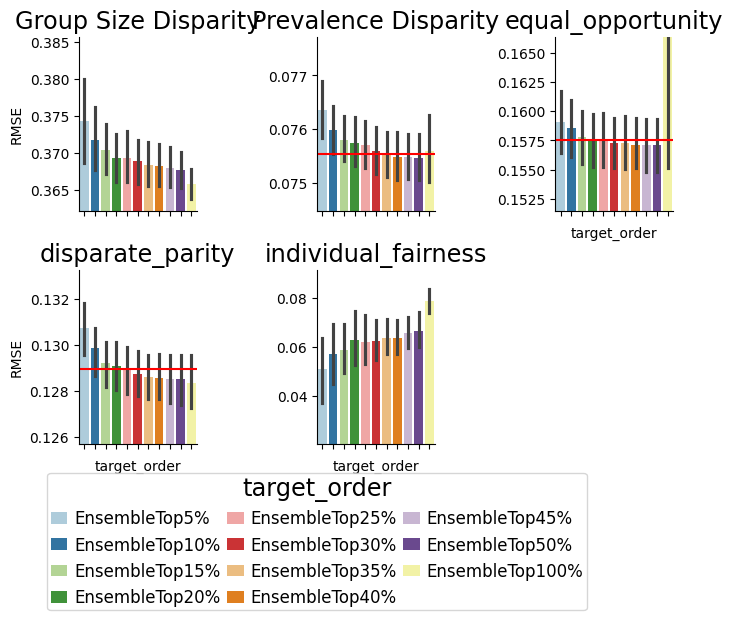

In [20]:
ensemble_chain_df=cv_result_df[cv_result_df["target_order"].isin(non_chain_models)]
display_full_result(ensemble_chain_df,"target_order","RMSE","Q3b_ensemble")